<a href="https://colab.research.google.com/github/anandyadav819/kaggle-notebooks/blob/main/Disneyland_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import os

In [ ]:
drive.mount("gdrive/")
#os.chdir("gdrive/My Drive/NLP/datasets/Disneyland Reviews/")
os.chdir("gdrive/My Drive/NLP/")

Mounted at gdrive/


In [ ]:
os.listdir()

['glove.6B.100d.txt',
 'glove.6B.50d.txt',
 'glove.6B.zip',
 'glove.pdf',
 '.index',
 'checkpoint',
 '.data-00000-of-00001',
 'models',
 'datasets',
 'training_checkpoints',
 'Neural Machine Translation',
 'training_checkpoints_lm',
 'Linkedin post',
 'Dataset',
 'Advanced NLP - Book.ipynb',
 'Text Generation.ipynb',
 'autocorrect_decoder_gru.h5',
 'autocorrect_encoder_gru.h5',
 'autocorrect_tokenizer.json',
 'TextRecommender.ipynb',
 'spacy_1.ipynb',
 'Disneyland Reviews.ipynb']

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from nltk.stem.snowball import SnowballStemmer
import tensorflow as tf

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
! python -m spacy download en_core_web_md

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
     |████████████████████████████████| 96.4MB 1.1MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.2.5-cp37-none-any.whl size=98051305 sha256=6d9873d803a6988bbd8082d0e204871298622b538bb4f71b9b52881c40443cc6
  Stored in directory: /tmp/pip-ephem-wheel-cache-5emvj0hj/wheels/df/94/ad/f5cf59224cea6b5686ac4fd1ad19c8a07bc026e13c36502d81
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [ ]:
nlp = spacy.load('en', disable=["tagger", "parser"])

In [ ]:
data = pd.read_csv("datasets/Disneyland Reviews/DisneylandReviews.csv", encoding="ISO-8859-1")

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42656 entries, 0 to 42655
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Review_ID          42656 non-null  int64 
 1   Rating             42656 non-null  int64 
 2   Year_Month         42656 non-null  object
 3   Reviewer_Location  42656 non-null  object
 4   Review_Text        42656 non-null  object
 5   Branch             42656 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.0+ MB


In [ ]:
data.describe()

,Review_ID,Rating
count,4.265600e+04,42656.000000
mean,3.188553e+08,4.217695
std,1.657092e+08,1.063371
min,1.398724e+06,1.000000
25%,1.743274e+08,4.000000
50%,2.907583e+08,5.000000
75%,4.489579e+08,5.000000
max,6.708014e+08,5.000000


In [ ]:
data.head()

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong
1,670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong
2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong
3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong
4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong


In [ ]:
print("Unique Reviewer Locations: ", len(list(set(data['Reviewer_Location']))))

Unique Reviewer Locations:  162


#EDA

In [ ]:
print("Unique Reviewer Locations: ", len(list(set(data['Year_Month']))))

Unique Reviewer Locations:  112


In [ ]:
data['Review_Year'] = data['Year_Month'].apply(lambda x:x.split('-')[0] if x!="missing" else x)
data['Review_Month'] = data['Year_Month'].apply(lambda x:x.split('-')[1] if x!="missing" else x)

## Rating

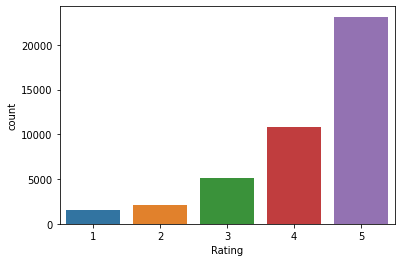

In [ ]:
#fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10, 10))
sns.countplot(x='Rating', data=data);
plt.show()

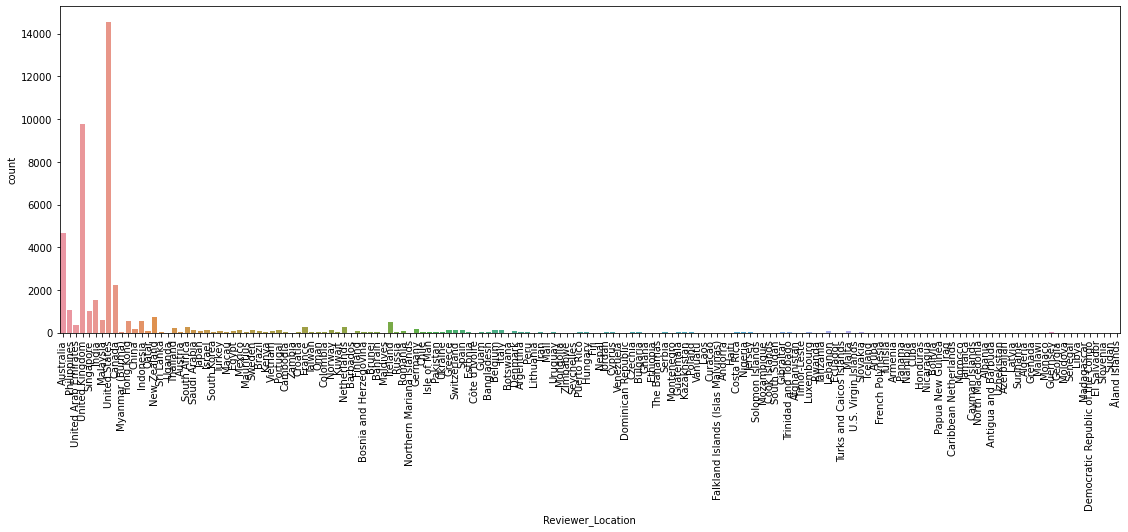

In [ ]:
plt.figure(figsize=(19, 6))
sns.countplot(x='Reviewer_Location', data=data);
plt.xticks(rotation=90)
plt.show()

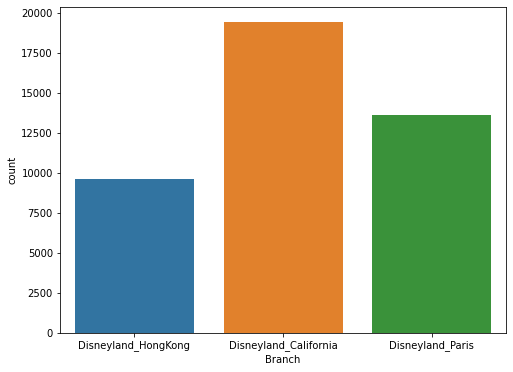

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Branch', data=data);
#plt.xticks(rotation=90)
plt.show()

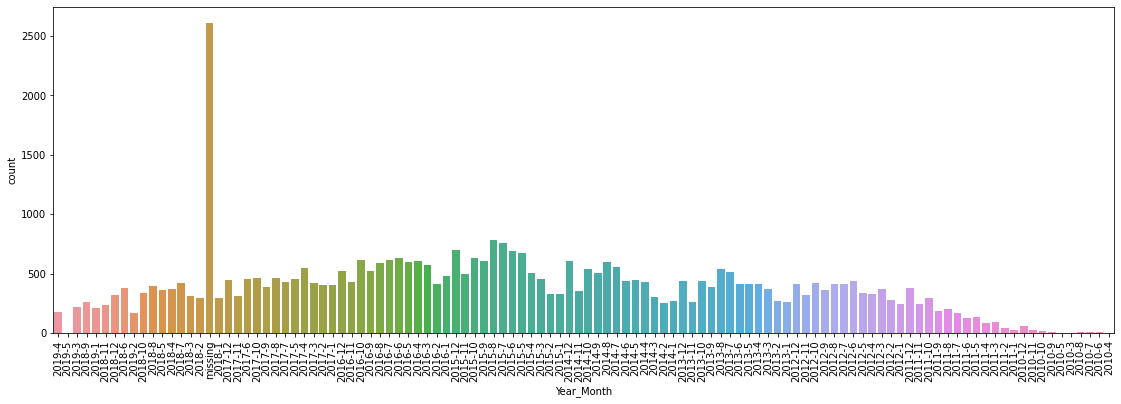

In [ ]:
plt.figure(figsize=(19, 6))
sns.countplot(x='Year_Month', data=data);
plt.xticks(rotation=90)
plt.show()

In [ ]:
data_wrt_rating = data[["Rating", "Branch"]].groupby('Branch').aggregate('mean')
data_wrt_rating['Rating'].head()

Branch
Disneyland_California    4.405339
Disneyland_HongKong      4.204158
Disneyland_Paris         3.960088
Name: Rating, dtype: float64

In [ ]:
data_wrt_yearmonth = data[["Rating", "Year_Month"]].groupby('Year_Month').aggregate('mean').reset_index().sort_values(by="Rating", ascending=False)
data_wrt_yearmonth

,Year_Month,Rating
4,2010-4,5.000000
0,2010-10,4.666667
3,2010-3,4.500000
57,2014-9,4.489152
60,2015-11,4.424547
...,...,...
16,2011-4,3.939759
32,2012-8,3.930288
2,2010-12,3.892857
14,2011-2,3.866667


In [ ]:
data_wrt_month = data[["Rating", "Review_Month"]].groupby('Review_Month').aggregate('mean').reset_index().sort_values(by="Rating", ascending=True)
data_wrt_month

,Review_Month,Rating
12,missing,4.012246
10,8,4.115423
8,6,4.194150
6,4,4.201553
4,2,4.204961
9,7,4.213402
5,3,4.215380
7,5,4.232335
3,12,4.235157
1,10,4.239373


In [ ]:
data_wrt_year = data[["Rating", "Review_Year"]].groupby('Review_Year').aggregate('mean').reset_index().sort_values(by="Rating", ascending=True)
data_wrt_year

,Review_Year,Rating
10,missing,4.012246
9,2019,4.111959
8,2018,4.136853
0,2010,4.167832
1,2011,4.214718
3,2013,4.223871
6,2016,4.234581
7,2017,4.235804
4,2014,4.241087
5,2015,4.259206


In [ ]:
data_wrt_loc = data[["Rating", "Reviewer_Location"]].groupby('Reviewer_Location').aggregate('mean').reset_index().sort_values(by="Rating", ascending=True)
data_wrt_loc

,Reviewer_Location,Rating
147,Turks and Caicos Islands,1.500000
136,Suriname,2.000000
132,South Sudan,2.000000
39,Ecuador,2.333333
58,Haiti,3.000000
...,...,...
54,Grenada,5.000000
123,Senegal,5.000000
81,Libya,5.000000
31,Cuba,5.000000


#Preprocessing

In [ ]:
def clean_text(x):
  
  #x = re.sub(r"\W", " ", x)
  x = re.sub(r"[0-9]", " ", x)
  x = re.sub(r"\s{2,}", " ", x)
  return x

def clean_text2(x):
  
  x = re.sub(r"\W", " ", x)
  #x = re.sub(r"[0-9]", " ", x)
  x = re.sub(r"\s{2,}", " ", x)
  x = re.sub(r"pron", "", x)
  return x


In [ ]:
print(clean_text("If you've ever     been to        Disneyland anywhere you..."))

If you've ever been to Disneyland anywhere you...


In [ ]:
all_stop_words = stopwords.words('english')
#all_stop_words.append("I")

In [ ]:
print(all_stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
wnl = WordNetLemmatizer()
stm = PorterStemmer()
sn_stm = SnowballStemmer('english')

In [ ]:
data_cp = data.copy(deep=True)

In [ ]:
docs = list(nlp.pipe(data_cp['Review_Text'].tolist()))

In [ ]:
for token in docs[4]:
  if token.lemma_!="-PRON-" or token.lemma_!="  ":
    print(token.lemma_)

In [ ]:
data_cp['Review_Text'] = [" ".join(i.lemma_ for i in j) for j in docs]

In [ ]:
data_cp['Review_Text'].head(5)

0    If -PRON- have ever be to Disneyland anywhere ...
1    Its be a while since have last time we visit H...
2    Thanks God it wasn    t too hot or too humid w...
3    HK Disneyland be a great compact park . Unfort...
4    the location be not in the city , take around ...
Name: Review_Text, dtype: object

In [ ]:
#data_cp['Review_Text'] = [" ".join(i.lemma_ for i in j) for j in docs]#data_cp['Review_Text'].apply(lambda x:" ".join([i.lemma_ for i in nlp(x)]))
#data_cp['Review_Text'] = data_cp['Review_Text'].apply(lambda x:" ".join([stm.stem(i) for i in x.split()]))
data_cp['Review_Text'] = data_cp['Review_Text'].apply(lambda x: clean_text(x))
data_cp['Review_Text'] = data_cp['Review_Text'].apply(lambda x:" ".join([i for i in x.lower().split() if i not in all_stop_words]))
data_cp['Review_Text'] = data_cp['Review_Text'].apply(lambda x: clean_text2(x))

In [ ]:
data_cp['Review_Text'].tolist()

['  ever disneyland anywhere  find disneyland hong kong similar layout walk main street familiar feel one ride small world absolutely fabulous worth day visit fairly hot relatively busy queue move fairly good ',
 'since last time visit hk disneyland yet time stay tomorrowland aka marvel land now iron man experience n newly open ant man n wasp ironman great feature n exciting especially whole scenery hk hk central area kowloon antman changed previous buzz lightyear little  expect something most however boy like it space mountain turns star wars great for cast member staff felt bite minus point dun feel like disney brand seems much local like ocean park even worst they get smiling face wanna u enter n attraction n leave hello suppose happiest place earth brand really feel it bakery main street much attractive delicacy n disney theme sweet good points last also starbucks inside theme park ',
 'thanks god hot humid visit park otherwise would big issue lot shade i arrive around leave p m un

In [ ]:
branch_lbl = LabelEncoder().fit_transform(data_cp['Branch'].tolist())
branch_dummy = pd.get_dummies(branch_lbl)
branch_dummy.shape

(42656, 3)

#Modelling

In [ ]:
tfidf = TfidfVectorizer(max_df=3000, min_df=200, ngram_range=(2, 3))

In [ ]:
text_feats = tfidf.fit_transform(data_cp['Review_Text'])
text_feats.shape

In [ ]:
all_feats = np.concatenate([text_feats.toarray(), branch_dummy], axis=1)

In [ ]:
all_feats.shape, text_feats.shape

((42656, 858), (42656, 855))

In [ ]:
target_rating = data_cp['Rating'].to_numpy()

In [ ]:
trainx, testx, trainy, testy = train_test_split(all_feats, target_rating, test_size=0.25, random_state=45)

In [ ]:
lr = LogisticRegression()
lr.fit(trainx, trainy)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
lr.score(testx, testy)

0.5689234808702176

#DL

##Sequential Model with new Embeddings

In [ ]:
#Load pretrained GloVe embeddings
dict_w2v = {}
with open('glove.6B.50d.txt', "r") as file:
    for line in file:
        tokens = line.split()
        word = tokens[0]
        vector = np.array(tokens[1:], dtype=np.float32)
        if vector.shape[0] == 50:
            dict_w2v[word] = vector
        else:
            print("There was an issue with " + word)
# let's check the vocabulary size
print("Dictionary Size: ", len(dict_w2v))

Dictionary Size:  400000


In [ ]:
include_ratings =[1, 3]
data_sub = data_cp[(data_cp['Rating']==1)|(data_cp['Rating']==3)].copy()
#data_sub = data_cp.copy()

In [ ]:
#data_sub['Rating'] = data_sub['Rating'].apply(lambda x: x-1)
data_sub['Rating'] = data_sub['Rating'].apply(lambda x: 0 if x==1 else 1)

In [ ]:
#data_sub[data_sub['Rating']==0][['Review_Text', 'Rating']].shape
data_sub.shape

(6608, 6)

In [ ]:
data_sub.shape

(6608, 6)

In [ ]:
NUM_WORDS = 10000
NUM_CLS = len(include_ratings)

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()

In [ ]:
all_text, all_labels = data_sub['Review_Text'].tolist(), data_sub['Rating'].tolist()

In [ ]:
tokenizer.fit_on_texts(all_text)

In [ ]:
NUM_WORDS = len(tokenizer.word_index) + 1
print(NUM_WORDS)

15581


In [ ]:
embedding_dim = 50
embedding_matrix = np.zeros((NUM_WORDS, embedding_dim))

In [ ]:
unk_cnt = 0
unk_set = set()
for word in tokenizer.word_index.keys():
    embedding_vector = dict_w2v.get(word)
    if embedding_vector is not None:
        tkn_id = tokenizer.word_index[word]
        embedding_matrix[tkn_id] = embedding_vector
    else:
        unk_cnt += 1
        unk_set.add(word)
# Print how many weren't found
print("Total unknown words: ", unk_cnt)

Total unknown words:  2975


In [ ]:
all_sequences = tokenizer.texts_to_sequences(all_text)

In [ ]:
all_padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(all_sequences, maxlen=80)

In [ ]:
train_x, val_x, train_y, val_y = train_test_split(all_padded_sequences, np.asarray(all_labels, dtype=np.int32), test_size=0.2)

In [ ]:
train_x.shape, val_x.shape, val_y.shape, train_y.shape

((5286, 80), (1322, 80), (1322,), (5286,))

In [ ]:
train_x, train_y = train_x[:(train_x.shape[0]//32)*32, :], train_y[:(train_y.shape[0]//32)*32]
val_x, val_y = val_x[:(val_x.shape[0]//32)*32, :], val_y[:(val_y.shape[0]//32)*32]

In [ ]:
class MergeHiddenStates(tf.keras.layers.Layer):
  def __init__(self):
    super(MergeHiddenStates, self).__init__()
  
  def call(self, inputs):
    #print(inputs)
    states = inputs#[0]
    return tf.reduce_mean(states, axis=1)

In [ ]:
def create_model(input_shape=(train_x.shape[1], ), vocabsize=NUM_WORDS, emb_dim=50, rnn_units=128, batch_size=32):
  model = tf.keras.Sequential([
                               tf.keras.layers.Embedding(
                                   vocabsize,
                                   emb_dim,
                                   mask_zero=False,
                                   batch_input_shape=(batch_size, input_shape[0]),
                                   weights=[embedding_matrix], trainable=False
                               ),
                               tf.keras.layers.Bidirectional(tf.keras.layers.GRU(rnn_units, dropout=0.2, return_sequences=True)),
                               MergeHiddenStates(),
                               tf.keras.layers.Dropout(0.3),
                               tf.keras.layers.Dense(128, activation='relu'),
                               tf.keras.layers.Dropout(0.2),
                               tf.keras.layers.Dense(NUM_CLS, activation='softmax')
  ])
  return model

In [ ]:
model = create_model()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (32, 80, 50)              779050    
_________________________________________________________________
bidirectional_1 (Bidirection (32, 80, 256)             138240    
_________________________________________________________________
merge_hidden_states_1 (Merge (32, 256)                 0         
_________________________________________________________________
dropout_2 (Dropout)          (32, 256)                 0         
_________________________________________________________________
dense_2 (Dense)              (32, 128)                 32896     
_________________________________________________________________
dropout_3 (Dropout)          (32, 128)                 0         
_________________________________________________________________
dense_3 (Dense)              (32, 2)                  

In [ ]:
loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
model.compile(loss=loss_obj, optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(train_x, train_y, batch_size=32, epochs=20, validation_data=(val_x, val_y), shuffle=True)

Epoch 1/20
165/165 [==============================] - 4s 14ms/step - loss: 0.5281 - accuracy: 0.7846 - val_loss: 0.4935 - val_accuracy: 0.7645
Epoch 2/20
165/165 [==============================] - 2s 9ms/step - loss: 0.4370 - accuracy: 0.8009 - val_loss: 0.4074 - val_accuracy: 0.8056
Epoch 3/20
165/165 [==============================] - 2s 9ms/step - loss: 0.4072 - accuracy: 0.8168 - val_loss: 0.4307 - val_accuracy: 0.7881
Epoch 4/20
165/165 [==============================] - 2s 10ms/step - loss: 0.4018 - accuracy: 0.8234 - val_loss: 0.4405 - val_accuracy: 0.8072
Epoch 5/20
165/165 [==============================] - 2s 10ms/step - loss: 0.3780 - accuracy: 0.8343 - val_loss: 0.4057 - val_accuracy: 0.8125
Epoch 6/20
165/165 [==============================] - 2s 9ms/step - loss: 0.3708 - accuracy: 0.8346 - val_loss: 0.4046 - val_accuracy: 0.8140
Epoch 7/20
165/165 [==============================] - 2s 9ms/step - loss: 0.3621 - accuracy: 0.8365 - val_loss: 0.3835 - val_accuracy: 0.8117
Epo

In [ ]:
val_preds = np.argmax(model.predict(val_x, batch_size=32), axis=1)

In [ ]:
val_preds.shape

(1312,)

In [ ]:
print(classification_report(val_y, val_preds))

              precision    recall  f1-score   support

           0       0.59      0.58      0.59       316
           1       0.87      0.87      0.87       996

    accuracy                           0.80      1312
   macro avg       0.73      0.73      0.73      1312
weighted avg       0.80      0.80      0.80      1312



In [ ]:
print(classification_report(val_y, val_preds))

              precision    recall  f1-score   support

           0       0.57      0.33      0.42       297
           1       0.28      0.05      0.09       401
           2       0.39      0.28      0.32      1016
           3       0.69      0.92      0.79      2158

    accuracy                           0.62      3872
   macro avg       0.48      0.40      0.41      3872
weighted avg       0.56      0.62      0.57      3872



##1D-CNN with Pretrained GloVe vectors

In [ ]:
include_ratings =[1, 3]
#data_sub = data_cp[data_cp['Rating']!=5].copy()
data_sub = data_cp[(data_cp['Rating']==1)|(data_cp['Rating']==3)|(data_cp['Rating']==3)].copy()

#data_sub['Rating'] = data_sub['Rating'].apply(lambda x: x-1)
data_sub['Rating'] = data_sub['Rating'].apply(lambda x: 0 if x==1 else 1)


tokenizer = tf.keras.preprocessing.text.Tokenizer()
all_text, all_labels = data_sub['Review_Text'].tolist(), data_sub['Rating'].tolist()
tokenizer.fit_on_texts(all_text)
all_sequences = tokenizer.texts_to_sequences(all_text)
all_padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(all_sequences, maxlen=100)
train_x, val_x, train_y, val_y = train_test_split(all_padded_sequences, np.asarray(all_labels, dtype=np.int32), test_size=0.2)
train_x, train_y = train_x[:(train_x.shape[0]//32)*32, :], train_y[:(train_y.shape[0]//32)*32]
val_x, val_y = val_x[:(val_x.shape[0]//32)*32, :], val_y[:(val_y.shape[0]//32)*32]

In [ ]:
NUM_WORDS = len(tokenizer.word_index) + 1
NUM_CLS = len(include_ratings)

In [ ]:
#Load pretrained GloVe embeddings
dict_w2v = {}
with open('glove.6B.50d.txt', "r") as file:
    for line in file:
        tokens = line.split()
        word = tokens[0]
        vector = np.array(tokens[1:], dtype=np.float32)
        if vector.shape[0] == 50:
            dict_w2v[word] = vector
        else:
            print("There was an issue with " + word)
# let's check the vocabulary size
print("Dictionary Size: ", len(dict_w2v))

Dictionary Size:  400000


In [ ]:
embedding_dim = 50
embedding_matrix = np.zeros((NUM_WORDS, embedding_dim))

In [ ]:
unk_cnt = 0
unk_set = set()
for word in tokenizer.word_index.keys():
    embedding_vector = dict_w2v.get(word)
    if embedding_vector is not None:
        tkn_id = tokenizer.word_index[word]
        embedding_matrix[tkn_id] = embedding_vector
    else:
        unk_cnt += 1
        unk_set.add(word)
# Print how many weren't found
print("Total unknown words: ", unk_cnt)

Total unknown words:  2975


In [ ]:
loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
model.compile(loss=loss_obj, optimizer='adam', metrics=['accuracy'])

In [ ]:
def create_model(vocab_size, embedding_dim, input_shape=(60, ), batch_size=32):
  model = tf.keras.Sequential([
                               tf.keras.layers.Embedding(vocab_size, embedding_dim, mask_zero=True, batch_input_shape=(batch_size, input_shape[0]),
                                                         weights=[embedding_matrix], trainable=False),
                               tf.keras.layers.Conv1D(32, 5, 1, 'valid', activation='relu'),
                               tf.keras.layers.MaxPool1D(),
                               tf.keras.layers.Conv1D(64, 3, 1, 'valid', activation='relu'),
                               tf.keras.layers.MaxPool1D(),
                               #tf.keras.layers.Conv1D(128, 3, 1, 'valid', activation='relu'),
                               #tf.keras.layers.MaxPool1D(),
                               #tf.keras.layers.Conv1D(256, 3, 1, 'valid', activation='relu'),
                               #tf.keras.layers.MaxPool1D(),
                               #tf.keras.layers.Conv1D(512, 1, 1, 'valid', activation='relu'),
                               #tf.keras.layers.MaxPool1D(),
                               tf.keras.layers.Flatten(),
                               tf.keras.layers.Dense(5, 'softmax')

  ])
  return model

In [ ]:
model = create_model(NUM_WORDS, embedding_dim, (train_x.shape[1],))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (32, 100, 50)             779050    
_________________________________________________________________
conv1d_10 (Conv1D)           (32, 96, 32)              8032      
_________________________________________________________________
max_pooling1d_10 (MaxPooling (32, 48, 32)              0         
_________________________________________________________________
conv1d_11 (Conv1D)           (32, 46, 64)              6208      
_________________________________________________________________
max_pooling1d_11 (MaxPooling (32, 23, 64)              0         
_________________________________________________________________
flatten_2 (Flatten)          (32, 1472)                0         
_________________________________________________________________
dense_6 (Dense)              (32, 5)                  

In [ ]:
model.compile(loss=loss_obj, optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(train_x, train_y, 32, 10, validation_data=(val_x, val_y))

Epoch 1/10
165/165 [==============================] - 1s 4ms/step - loss: 0.6261 - accuracy: 0.7494 - val_loss: 0.4617 - val_accuracy: 0.7919
Epoch 2/10
165/165 [==============================] - 0s 3ms/step - loss: 0.4397 - accuracy: 0.8073 - val_loss: 0.4395 - val_accuracy: 0.7957
Epoch 3/10
165/165 [==============================] - 0s 3ms/step - loss: 0.3764 - accuracy: 0.8432 - val_loss: 0.4297 - val_accuracy: 0.8049
Epoch 4/10
165/165 [==============================] - 1s 3ms/step - loss: 0.3105 - accuracy: 0.8746 - val_loss: 0.4734 - val_accuracy: 0.8026
Epoch 5/10
165/165 [==============================] - 1s 3ms/step - loss: 0.2444 - accuracy: 0.9074 - val_loss: 0.4634 - val_accuracy: 0.7980
Epoch 6/10
165/165 [==============================] - 1s 3ms/step - loss: 0.2157 - accuracy: 0.9267 - val_loss: 0.5371 - val_accuracy: 0.8026
Epoch 7/10
165/165 [==============================] - 1s 4ms/step - loss: 0.1494 - accuracy: 0.9514 - val_loss: 0.5655 - val_accuracy: 0.7873
Epoch 

In [ ]:
val_preds = np.argmax(model.predict(val_x, batch_size=32), axis=1)
print(classification_report(val_y, val_preds))

              precision    recall  f1-score   support

           0       0.56      0.30      0.39       288
           1       0.83      0.93      0.88      1024

    accuracy                           0.79      1312
   macro avg       0.69      0.62      0.63      1312
weighted avg       0.77      0.79      0.77      1312

